# 프로젝트 : SRGAN 활용하기
앞에서 사용했던 SRGAN 구조를 이용해 프로젝트를 수행해 봅시다.

## 목차
[프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기](#프로젝트-1-:-직접-고른-이미지로-SRGAN-실험하기)   
[프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기](#프로젝트-2-:-SRGAN을-이용해-고해상도-gif-생성하기)  
[Rubric](#Rubric)  
[회고](#회고)

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
---
이제 여러분이 직접 다른 이미지를 사용해 볼 차례입니다.

앞서 사용했던 `DIV2K` 데이터셋은 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4로 줄인 저해상도 이미지와 원래 고해상도 이미지 사이에서 학습되었습니다. 이 데이터셋으로 학습된 SRGAN를 이용해 좋은 결과를 얻기 위해서는 위와 같은 과정이 동일하게 진행되는 것이 좋습니다.

아래와 같이 두 가지 다른 단계를 거쳐서 직접 고른 이미지에 대해 SRGAN을 적용해 봅시다. 테스트할 이미지를 고를 때, `DIV2K` 의 학습 데이터셋과 비슷한 종류의 이미지가 좋습니다. 일반적으로 자연, 동물, 건물 등의 이미지가 학습에 사용되었으며, 이와 달리 애니메이션 등의 이미지는 고해상도로 잘 변환되지 않을 수 있습니다.

특정 데이터셋에서만 학습되었기 때문에, 일반적으로 좋지 않은 결과가 나올 가능성이 높습니다. 결과와 상관없이 아래 과정만 잘 수행해봅시다.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

### 프로젝트 1-1.

1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 `cv2.resize()`를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

#### 1. 고해상도 이미지 불러오기

(1800, 2400, 3)


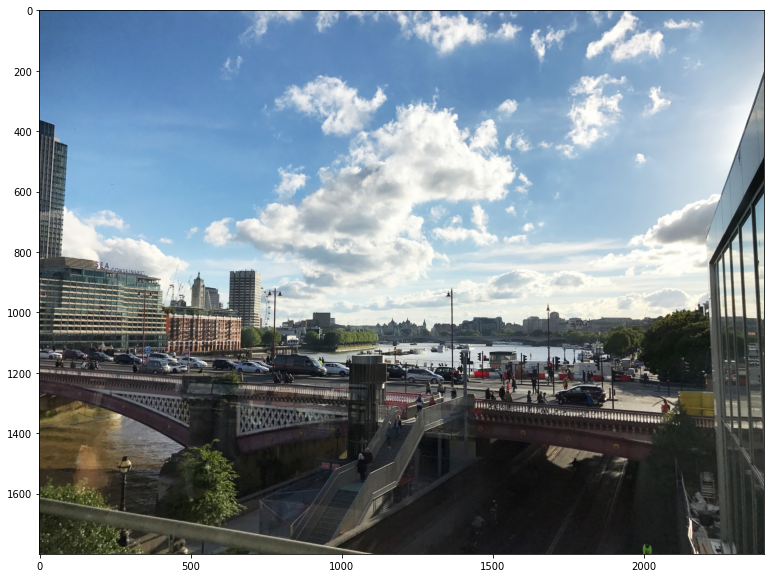

In [2]:
hr_path = os.getenv('HOME') + '/aiffel/super_resolution/images/london_01.jpg'
hr_image = cv2.imread(hr_path)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(20, 10))
plt.imshow(hr_image)

#### 2. bicubic interpolation을 적용해 가로 및 세로 픽셀 수 1/4로 줄이기

(450, 600, 3)


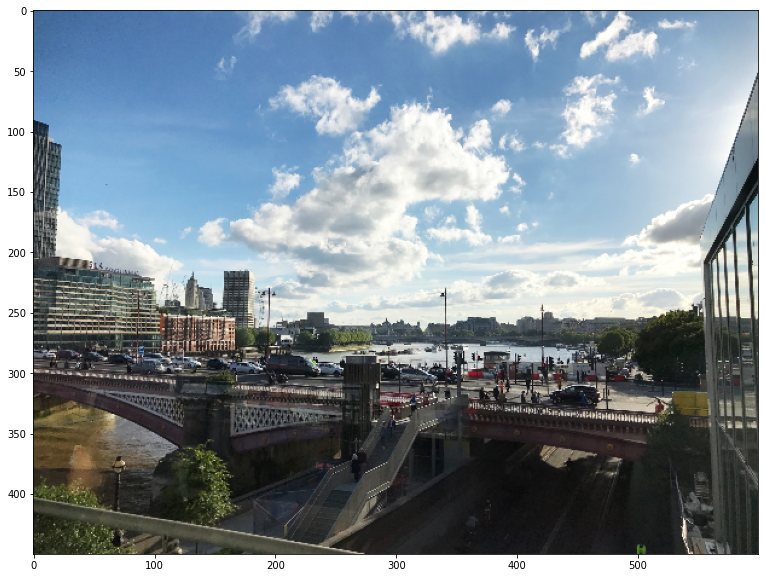

In [3]:
bicubic_lr = cv2.resize(hr_image, dsize=(hr_image.shape[1]//4, hr_image.shape[0]//4), interpolation=cv2.INTER_CUBIC)
print(bicubic_lr.shape)

plt.figure(figsize=(20,10))
plt.imshow(bicubic_lr)

#### 3. 줄인 저해상도 이미지를 입력해, SRGAN을 이용해 고해상도 이미지를 생성

In [4]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

(1800, 2400, 3)


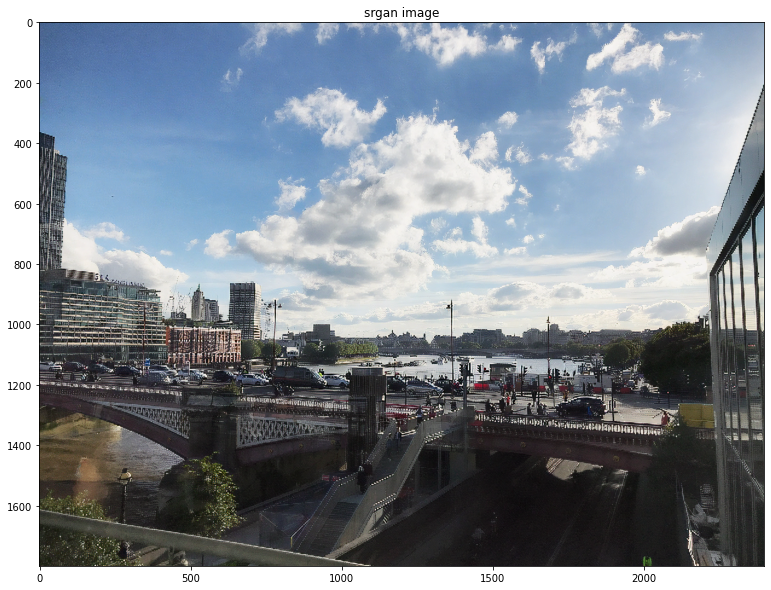

In [6]:
srgan_hr = apply_srgan(bicubic_lr)

print(srgan_hr.shape)

plt.figure(figsize=(20,10))
plt.title('srgan image')
plt.imshow(srgan_hr)

#### 4. 2.의 이미지에 bicubic interpolation을 적용해 가로, 세로 픽셀 수를 다시 4배로 늘리기

(1800, 2400, 3)


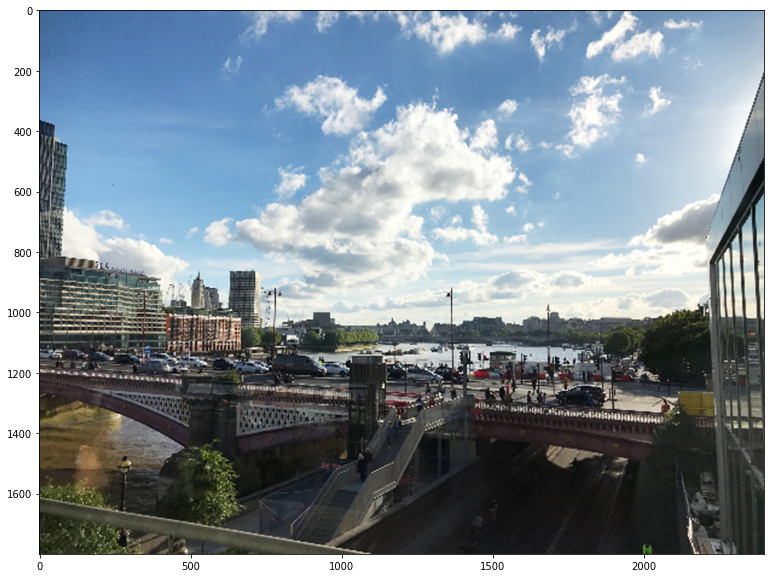

In [7]:
bicubic_hr = cv2.resize(bicubic_lr, dsize=(hr_image.shape[1], hr_image.shape[0]), interpolation=cv2.INTER_CUBIC)
print(bicubic_hr.shape)

plt.figure(figsize=(20,10))
plt.imshow(bicubic_hr)

#### 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화

In [8]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

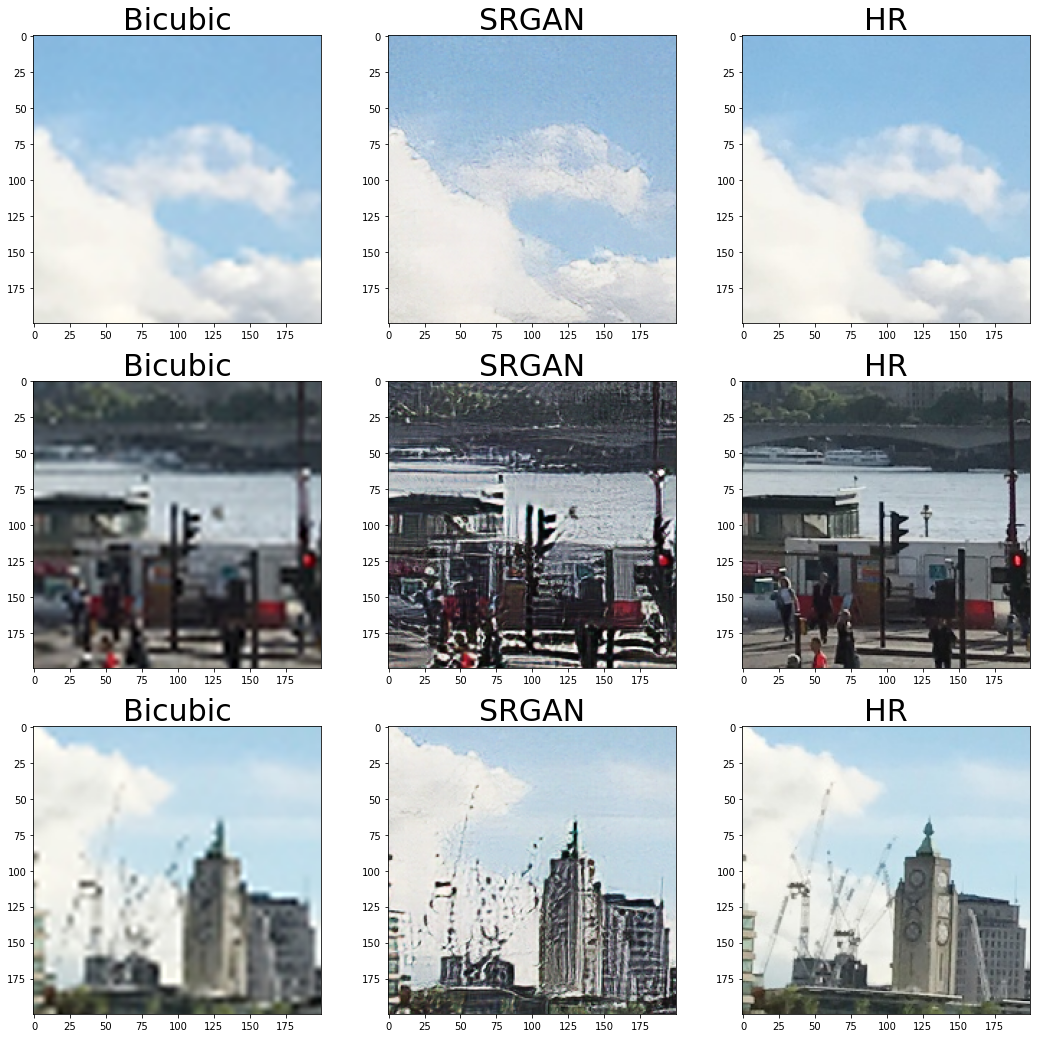

In [9]:
left_tops = [(600,100), (1050,1500), (800,400)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr, left_top, 200, 200)
    img3 = crop(hr_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

#### 6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때의 결과

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


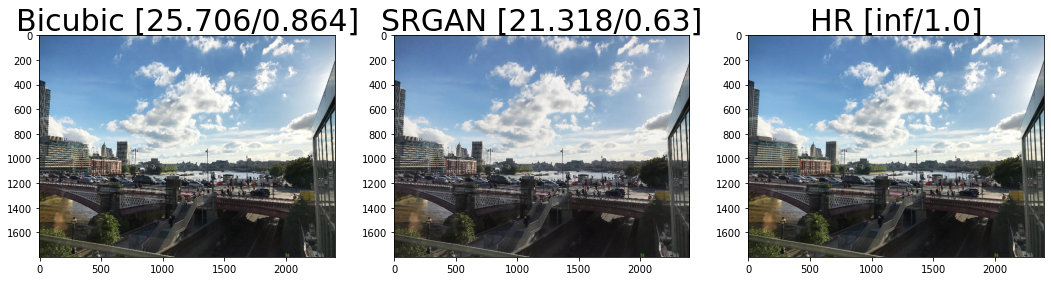

In [10]:
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

psnr = [round(peak_signal_noise_ratio(hr_image, i), 3) for i in images]
ssim = [round(structural_similarity(hr_image, i, multichannel=True), 3) for i in images]

plt.figure(figsize=(18,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

정량적 평가 방식인 **PSNR**과 **SSIM**을 사용했을 때, 오히려 **Bicubic**이 **SRGAN**에 비해 높은 평가 수치를 가지는 것을 볼 수 있었다.

- Bicubic 이미지가 고화질 이미지에 비해 흐린 이미지라면,
- SRGAN 이미지는 가장자리에 대한 선명한 필터를 준 것처럼  뚜렷해지지만, 대체로 과한 필터링을 거친 느낌을 준다.
- 특히 기중기 부분에서는 픽셀끼리 뭉치는 것처럼 보여 오히려 이러한 결과로 인해, 원본 이미지와 결과물 비교 수치에서는 더 낮은 점수를 가지는 것으로 보인다.
 

### 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. `cv2.resize()`를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

#### 1. 저해상도 이미지 불러오기

(1560, 1170, 3)


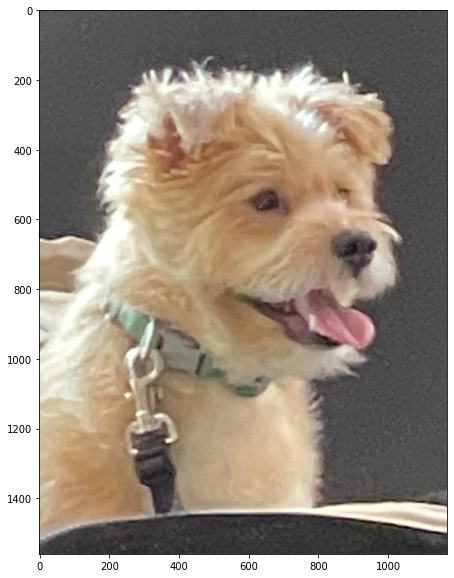

In [11]:
lr_path = os.getenv('HOME') + '/aiffel/super_resolution/images/puppy.jpg'
lr_image = cv2.imread(lr_path)
lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)

print(lr_image.shape)

plt.figure(figsize=(20, 10))
plt.imshow(lr_image)

#### 2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성

(390, 292, 3)


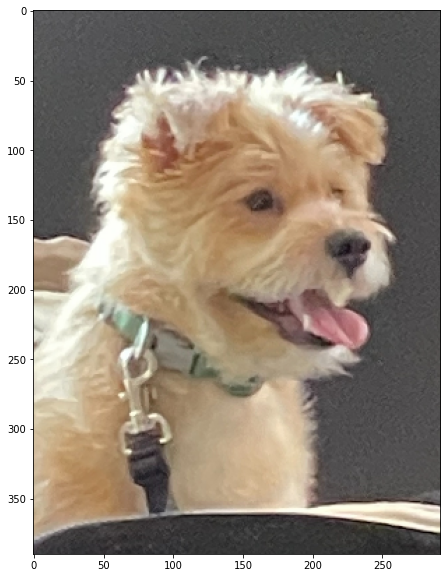

In [12]:
resized_lr = cv2.resize(lr_image, dsize=(lr_image.shape[1]//4, lr_image.shape[0]//4), interpolation=cv2.INTER_CUBIC)
print(resized_lr.shape)

plt.figure(figsize=(20,10))
plt.imshow(resized_lr)

(1560, 1168, 3)


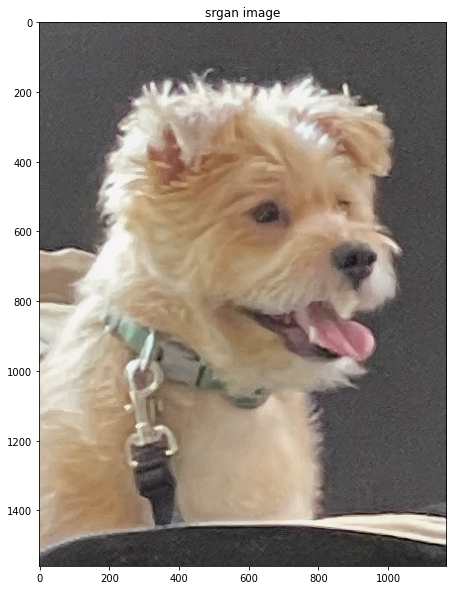

In [13]:
srgan_hr = apply_srgan(resized_lr)

print(srgan_hr.shape)

plt.figure(figsize=(20,10))
plt.title('srgan image')
plt.imshow(srgan_hr)

#### 3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해, 가로, 세로 픽셀 수를 다시 4배로 늘리기

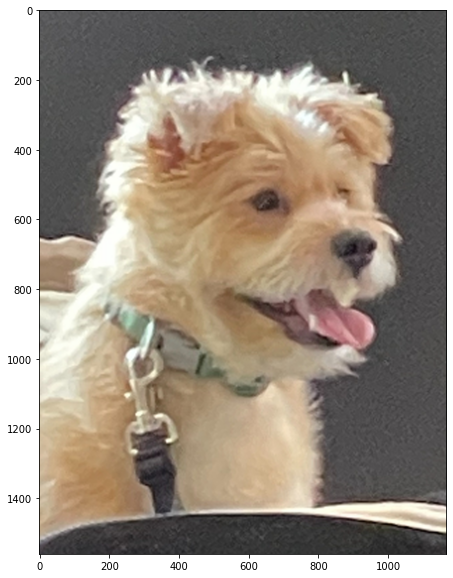

In [14]:
bicubic_hr = cv2.resize(resized_lr, 
dsize=(resized_lr.shape[1]*4, resized_lr.shape[0]*4),
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,10))
plt.imshow(bicubic_hr)

#### 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화

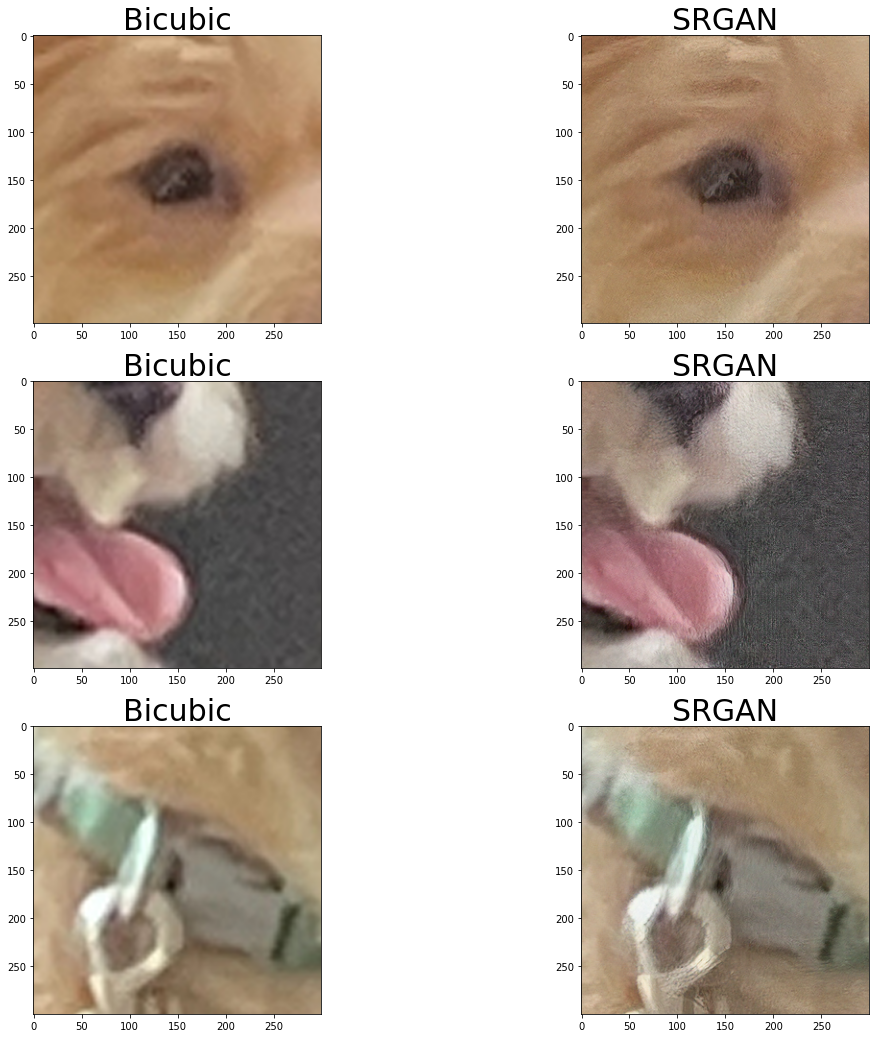

In [15]:
left_tops = [(400,500), (700,800), (800,200)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 300, 300)
    img2 = crop(srgan_hr , left_top, 300, 300)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

#### 5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때의 결과

- 각 Bicubic과 SRGAN 이미지에 대한 결과는 두 사진을 놓고 비교했을 때, 조금 더 그림 효과를 준 것처럼 사진이 오히려 부드러워진 느낌을 받았다.  
- 각 부분으로 자른 사진을 봤을 때, SRGAN에서 경계를 더 뚜렷하게 주기 위해서 생긴 효과인지 모르겠지만, 붓 터치 효과를 준 것 처럼 질감이 더 두드러지고 좀 더 입체감이 생긴 느낌이다.

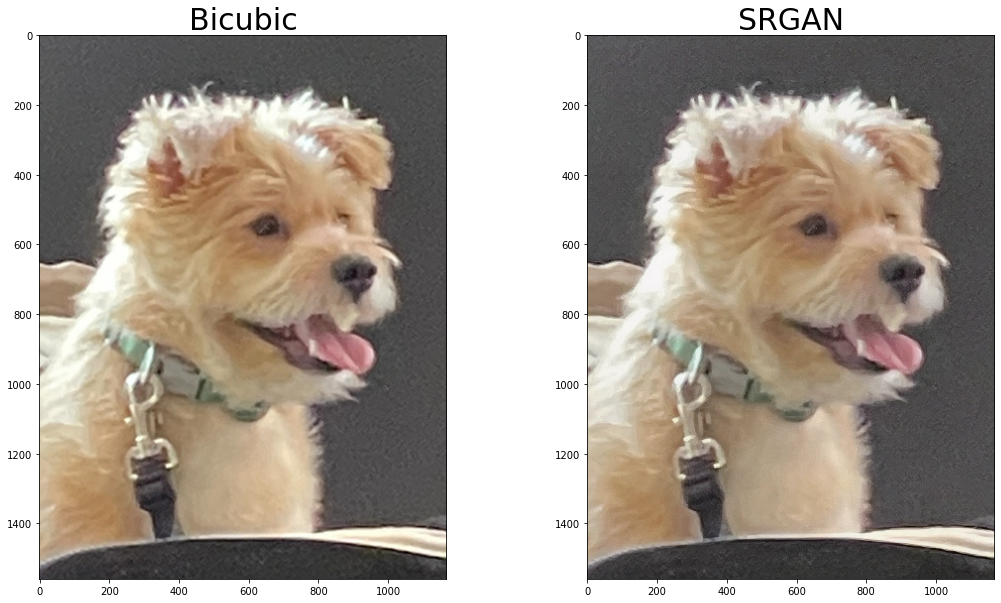

In [16]:
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(18,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i], fontsize=30)

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기
---
이전 Super Resolution의 활용 사례에 대해 살펴봤을 때, 단일 이미지가 아닌 영상에 대해 Super Resolution을 적용한 사례가 있었습니다. 이번에는 이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행해 봅시다.

실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요됩니다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 봅시다.

각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치가 필요합니다.

In [17]:
# !pip install imageio

### 1. gif 파일 불러오기
---
아래 주소에 몇 개의 gif 파일이 있습니다. 이 중 하나를 골라 다운로드하여 아래 과정을 수행합시다. (한 개 이상의 gif 파일에 대해 아래 과정을 수행해야 합니다!)

**GIF files** https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e

다운받은 gif 파일을 아래와 같은 과정을 통해 각 프레임(이미지)을 불러올 수 있습니다. `frames`이란 리스트 안에 각각의 프레임이 들어 있습니다.

In [18]:
gif_path = os.getenv('HOME')+'/aiffel/super_resolution/images'
gif = cv2.VideoCapture(gif_path + '/city_night_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


### 2. 프레임별 Super Resolution 진행하기
---
Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 `frames_sr`이라는 리스트에 넣어주세요.

In [19]:
frames_sr_bicubic = []

for i in frames:
    bicubic_hr = cv2.resize(i, dsize=(i.shape[1]*4, i.shape[0]*4), interpolation=cv2.INTER_CUBIC)
    frames_sr_bicubic.append(bicubic_hr)

In [20]:
frames_sr_srgan = []

for i in frames:
    frames_sr_srgan.append(apply_srgan(i))

### 3. 프레임을 합쳐 gif 만들기
---
위에서 `frame_sr`을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있습니다. Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들어 주세요.

In [21]:
import imageio

imageio.mimsave("bicubic.gif", frames_sr_bicubic)
imageio.mimsave("srgan.gif", frames_sr_srgan)

### 4. Jupyter notebook에 gif 표시하기
---
아래와 같이 다운받은 저해상도 gif 파일과 고해상도 gif 파일을 각각 jupyter 내에 출력하여 최종 제출해 주시면 됩니다. jupyter 내에 출력이 어려운 경우, GitHub에 저해상도, 고해상도 gif파일을 업로드 후 링크를 첨부해주시기바랍니다. Super Resolution이 잘 적용되었는지 시각적으로 확인하기 위해 아래의 width 옵션을 적당히 크게 해주세요. 저해상도 및 고해상도 시각화의 width 값은 같도록 설정해주세요.

#### 저해상도 gif 파일

In [22]:
from IPython.display import Image as show_gif
# show_gif("images/city_night_lr.gif", width=800)

![low_resolution_gif](/data/16_super_resolution/city_night_lr.gif)

#### bicubic gif 파일

In [23]:
# show_gif("bicubic.gif", width=800) # width 는 적당히 큰 값으로 설정해주세요

![BICUBIC_gif](/data/16_super_resolution/bicubic.gif)

#### srgan gif 파일

In [24]:
# show_gif("srgan.gif", width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

![SRGAN_gif](/data/16_super_resolution/srgan.gif)

## Rubric

||**평가 문항**|**상세 기준**|
|:--------|:--------|:--------|
|**1**|SRGAN을 이용해 고해상도의 이미지를 생성하였다.|SRGAN을 통해 생성된 이미지를 제출하였다.|
|**2**|다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.|이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.|
|**3**|저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.|저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.|

#### 1 SRGAN을 이용해 고해상도의 이미지를 생성하였다.
#### 2 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.
#### 3 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.

## 회고
SRGAN을 이용해 저화질 이미지를 고화질로 만들어 낼 수 있다는 것 자체가 신기하고 흥미로웠고, 그래서 재미있게 이번 노드를 진행했다.

#### 알게 된 점
이번 모델에서의 각각의 성능에 대해,
- Bicubic은 이미지를 좀 더 부드럽게 만드는 느낌을 받았다면,  
- SRGAN에서는 반대로 이미지를 더 선명하게 만들기 위해서인지 텍스처가 거칠게 생기면서 입체감을 주는 느낌이었다.
(특히 가장자리 부분에서 두드러지는데, 그래서인지 강아지 사진에서는 오히려 그림 효과를 준 것과 같은 느낌이 살짝 들었다.)

#### 느낀 점
이번 모델에서 만들어 낼 수 있는 성능으로는 아직 고화질의 사진을 잘 만든다고 할 수는 없겠지만, 어느 정도 가시적인 효과가 보이는 것 같아서 재미있었다.

다른 GAN 모델에 대해서도 차차 알아가는 시간을 가져야 할 것 같다.

이미지를 업로드하는 데서도, 우용님이 좋은 방법을 알려주셔서 무사히 잘 올릴 수 있었다.